## Compare range and range-rate between poliastro and JPL Horizons

In [ ]:
! pip3 install astropy jplephem poliastro

In [ ]:
from astropy import units as au
from astropy import coordinates as ac
from astropy import constants as ak
from astropy import time as at
from poliastro.bodies import Venus
from poliastro.frames.fixed import VenusFixed
from poliastro.frames.equatorial import VenusICRS
from poliastro.spheroid_location import SpheroidLocation
import numpy as np

# Set high quality ephemerides
# https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de440_and_de441.pdf appears to recommend de440s for our purposes:
# - de440s : 1849 to 2150 (32 MB)
# - de440 : 1550 to 2650 (114 MB)
# - de441 : -13200 to 17191(3.2 GB)
ac.solar_system_ephemeris.set("de440s")  # JPL Horizons is using de441, which is in the same de44X family. 

obstime = at.Time('2013-06-12') + 10000 * au.s
#obstime = at.Time('2015-06-12') + 5000 * au.s

# Observer point (Arecibo) to ICRS posvel
o_coord = ac.EarthLocation.of_site('arecibo')
#o_coord = ac.EarthLocation.from_geocentric(0, 0, 0, au.m)  # Body center of Earth
o_gcrs = o_coord.get_gcrs(obstime)
print(f' {o_gcrs.velocity=}')
o_icrs = o_gcrs.transform_to(ac.ICRS())
#print('Arecibo _ ICRS:')
#print(f' {o_icrs.cartesian=}')
#print(f' {o_icrs.velocity=}')

# Point on Venus to IRCS (position and velocity)
v0 = SpheroidLocation(0.0 * au.deg, 0.0 * au.deg, 0.0 * au.m, Venus)  # Planetodetic origin: (lon, lat, height)
#v0 = SpheroidLocation(0.0 * au.deg, 90.0 * au.deg, 0.0 * au.m, Venus)  # Venus north pole
#v0 = SpheroidLocation(20.0 * au.deg, 30.0 * au.deg, 0.0 * au.m, Venus)  # Planetodetic coordinates: (lon, lat, height)
x, y, z = v0.cartesian_cords
# Note: I don't think VenusFixed should really need an obstime, but leaving it blank causes trouble when transforming
# to VenusICRS. Might be a problem.
v_fixed = VenusFixed(obstime=obstime,
                     x=x, y=y, z=z,
#                     x=0 * au.m, y=0 * au.m, z=0 * au.m,  # Body center of Venus
                     v_x=0 * au.m / au.s, v_y=0 * au.m / au.s, v_z=0 * au.m / au.s,
                     representation_type='cartesian', differential_type='cartesian')
# WORKAROUND: have to go through VenusICRS frame because something is busted about obstime in VenusFixed?!?
#VenusICRS(obstime=obstime)
v_vicrs = v_fixed.transform_to(VenusICRS(obstime=obstime))
v_icrs = v_vicrs.transform_to(ac.ICRS())
print(f' {v_vicrs.velocity=}')
#v_icrs = v_fixed.transform_to(ac.ICRS())
#print('Venus point _ ICRS:')
#print(f' {v_icrs.cartesian=}')
print(f' {v_icrs.velocity=}')

# Delta position and velocity
dpos = v_icrs.cartesian.without_differentials() - o_icrs.cartesian.without_differentials()
dvel = v_icrs.velocity - o_icrs.velocity

#range = dpos.norm()
#print(f'{range=}')
dpos_m = dpos.xyz.to(au.m).value
dvel_mps = dvel.d_xyz.to(au.m / au.s).value

# "Radial" and "Orthogonal" velocity
range_m = np.sqrt(np.sum(dpos_m**2))
range_rate_mps = np.dot(dvel_mps, dpos_m / range_m)
ortho_mps = np.sqrt(sum(dvel_mps**2) - range_rate_mps**2)
print(f'{range_m=}')
print(f'{range_rate_mps=}')
print(f'{ortho_mps=}')
print('next range_m (1s):', range_m + range_rate_mps)

In [ ]:
# Compare poliastro results with JPL Horizons queries.

from astroquery.jplhorizons import Horizons

# NOTE: I swear I had to telnet to horizons ("telnet horizons.jpl.nasa.gov 6775") and query using the surface target
# format ("g: 0, 0, 0 @ 299") and then surface queries started magically working...

obj = Horizons(
#    id='g: 0, 90, 0 @ 299',   # Venus north pole
    id='g: 0, 0, 0 @ 299',    # Planetodetic origin (lon, lat, height)
#    id='g: 20, 30, 0 @ 299',  # Planetodetic (lon, lat, height) of a point on Venus
#    id='299',  # Venus (Body center? Barycenter?)
#    id='399',  # Earth (Body center? Barycenter?)
    location='-1 @ 399',  # Arecibo on Earth
#    location='@399',  # Earth
#    location='500 @ 0',  # Solar system barycenter (SSB) == ICRS origin, but perhaps not the orientation??
    epochs=obstime.tdb.jd)  # NOTE: use *obstime.tdb.jd* for *vectors* output!
#eph = obj.ephemerides()    # NOTE: use obstime.jd for ephemerides output
vec = obj.vectors()         # NOTE: use obstime.tdb.jd for vectors output
#vec.show_in_notebook()

In [ ]:
# Compare AstroPy/PoliAstro with JPL Horizons (See "FOUND ISSUE: JPL Horizons ICRS" below for why only range and
# range-rate are comparable)

# Comparing the Venus body center, we get errors on the order of range: 200 m and range-rate: 0.02 m/s.
# (These low errors also apply to the north and south poles.)
# Whereas for a point on the surface of Venus, we get errors on the order of range: 200 m and range-rate: 1 m/s.
# This points to some Venus rotation issue between poliastro and JPL Horizons.

jpl_range = vec['range'][0] * vec['range'].unit
jpl_range_rate = vec['range_rate'][0] * vec['range_rate'].unit
jpl_range_m = jpl_range.to(au.m).value
jpl_range_rate_mps = jpl_range_rate.to(au.m / au.s).value
print(f'{jpl_range_m=}')
print(f'{jpl_range_rate_mps=}')
print('next jpl_range_m (1s)', jpl_range_m + jpl_range_rate_mps)

print('range error (m)', range_m - jpl_range_m)
print('range_rate error (m/s)', range_rate_mps - jpl_range_rate_mps)

In [ ]:
# Search for a constant rotational offset??  Under the theory that the rotation of Venus is offset somehow?
for dlon in np.linspace(-0.1, 0.1, 201):
    v0 = SpheroidLocation((20.0 + dlon) * au.deg, 30.0 * au.deg, 0.0 * au.m, Venus)  # Planetodetic coordinates: (lon, lat, height)
    x, y, z = v0.cartesian_cords
    v_fixed = VenusFixed(obstime=obstime,
                         x=x, y=y, z=z,
                         v_x=0 * au.m / au.s, v_y=0 * au.m / au.s, v_z=0 * au.m / au.s,
                         representation_type='cartesian', differential_type='cartesian')
    v_vicrs = v_fixed.transform_to(VenusICRS(obstime=obstime))
    v_icrs = v_vicrs.transform_to(ac.ICRS())

    # Delta position and velocity
    dpos = v_icrs.cartesian.without_differentials() - o_icrs.cartesian.without_differentials()
    dvel = v_icrs.velocity - o_icrs.velocity
    dpos_m = dpos.xyz.to(au.m).value
    dvel_mps = dvel.d_xyz.to(au.m / au.s).value
    # "Radial" and "Orthogonal" velocity
    range_m = np.sqrt(np.sum(dpos_m**2))
    range_rate_mps = np.dot(dvel_mps, dpos_m / range_m)
    print(f'{dlon:0.3f}  range error (m) {range_m - jpl_range_m:0.3f}  range rate error (m/s) {range_rate_mps - jpl_range_rate_mps:0.3f}')

## Sanity Tests (or lack thereof)

In [ ]:
# SANITY TEST
# I've checked that the poliastro BodyFixed and astropy EarthLocation coordinates indeed match with the
# get_body_barycentric* family of calls (at least when the proper ephemeris is specified).

# FOUND ISSUE: JPL Horizons ICRS frame center and orientation:
# However, it is somewhat difficult to compare the get_body_* results with JPL Horizons, because Horizons returns
# results in the ICRS frame but shifted *relative* to the specific coordinate center (observer):  even when that
# coordinate center is set to the Solar System Barycenter (SSB) "500@0", it is clear that the *orientation* of the
# frames is off, though the range and range rates are only off by something like 10 km and 0.5 km/d respectively.

# FOUND ISSUE: For ?reasons?, "the epoch of the ephemerides request is assumed to be in UTC JD by default (so
# obstime.utc.jd), while the epoch for the vectors request are required to be in TDB JD (so obstime.tdb.jd)."
# SO when I use obstime.tbd.jd in the Horizons vector request, I get errors on the order range 1e-5 km and
# range-rate 1e-6 km/d!!! (though the orientation issue still persists, of course).
# NOTE: I get significantly larger errors when using a planetodetic coordinates (100 m, 1 m/s)

from astropy import coordinates as ac
from astropy import time as at
from astropy import units as au
from astroquery.jplhorizons import Horizons

obstime = at.Time('2015-08-12')

obj = Horizons(
    id='299',  # Venus (Body center? Barycenter?)
    #id='399',  # Earth (Body center? Barycenter?)
    location='500 @ 0',  # Solar system barycenter (SSB) == ICRS origin, ambiguous orientation??
    epochs=obstime.tdb.jd)  # NOTE: use of *TDB* is required for *vectors* output!
vec = obj.vectors()
v_hor = ac.CartesianRepresentation(
    x=vec['x'][0] * vec['x'].unit,
    y=vec['y'][0] * vec['y'].unit,
    z=vec['z'][0] * vec['z'].unit)
dv_hor = ac.CartesianRepresentation(
    x=vec['vx'][0] * vec['vx'].unit,
    y=vec['vy'][0] * vec['vy'].unit,
    z=vec['vz'][0] * vec['vz'].unit)
print(v_hor.xyz.to(au.AU), dv_hor.xyz.to(au.AU / au.d))

v_pol, dv_pol = ac.get_body_barycentric_posvel('venus', obstime, ephemeris='de440s')
#v_pol, dv_pol = ac.get_body_barycentric_posvel('earth', obstime, ephemeris='de440s')
print(v_pol.xyz.to(au.AU), dv_pol.xyz.to(au.AU / au.d))

print('position error', (v_pol - v_hor).norm())
print('velocity error', (dv_pol - dv_hor).norm())
print('range error', (v_pol.norm() - v_hor.norm()).to(au.m))
print('range rate error', (dv_pol.norm() - dv_hor.norm()).to(au.m / au.s))

In [1]:
# SANITY TEST
# Check Geodetic (EarthLocation) and Planetodetic (SpheroidLocation) to cartesian coordinates.

# FOUND ISSUE: Unexpected Cartesian frame for Spheroid Location (affects poliastro 0.17.0, but has been fixed in
# 0.18.dev0)
# FIX: pip install from the poliastro repo!

from astropy import coordinates as ac
from astropy import units as au
from poliastro.spheroid_location import SpheroidLocation
from poliastro.bodies import Earth

lon = 20.0 * au.deg
lat = 60.0 * au.deg
h = 0.0 * au.m

p0 = ac.EarthLocation.from_geodetic(lon, lat, h)
p1 = SpheroidLocation(lon, lat, h, Earth)
print(f'{p0=}')
print(f'{p1.cartesian_cords=}')

print('error', p1.distance(p0.x, p0.y, p0.z))


p0=<EarthLocation (3004295.58821321, 1093474.16904688, 5500477.13393864) m>
p1.cartesian_cords=<Quantity [3004295.40531655, 1093474.10247794, 5500476.77210492] m>
error 0.41086037868362074 m


In [ ]:
# SANITY TEST
# Check the velocity of a planetodetic in the ICRS frame

from astropy import coordinates as ac
from astropy import units as au
from poliastro.spheroid_location import SpheroidLocation
from poliastro.bodies import Earth

ac.solar_system_ephemeris.set("de440s")  # JPL Horizons is using de441, which is in the same de44X family. 

obstime = at.Time('2015-09-12')

lon = 20.0 * au.deg
lat = 40.0 * au.deg
h = 0.0 * au.m

o_coord = ac.EarthLocation.from_geodetic(lon, lat, h)
#o_coord.get_itrs()
o_gcrs = o_coord.get_gcrs(obstime)
#print(f' {o_gcrs.cartesian=}')
#print(f' {o_gcrs.velocity=}')
o_icrs = o_gcrs.transform_to(ac.ICRS())
print(f' {o_icrs.velocity=}')

# Nice to check... but this doesn't test poliastro's BodyFixed and BodyICRS frames.
v0 = SpheroidLocation(lon, lat, h, Earth)
x, y, z = v0.cartesian_cords
v_fixed = ac.ITRS(  # ITRS is analogous to VenusFixed
    obstime=obstime,
    x=x, y=y, z=z,
    v_x=0 * au.m / au.s, v_y=0 * au.m / au.s, v_z=0 * au.m / au.s,
    representation_type='cartesian', differential_type='cartesian')
v_gcrs = v_fixed.transform_to(ac.GCRS(obstime=obstime))  # GCRS is analogous to VenusICRS
#print(f' {v_gcrs.cartesian=}')
#print(f' {v_gcrs.velocity=}')
v_icrs = v_gcrs.transform_to(ac.ICRS())
print(f' {v_icrs.velocity=}')

print('velocity error', o_icrs.velocity - v_icrs.velocity)
print('velocity error mag', (o_icrs.velocity - v_icrs.velocity).norm())


In [42]:
# SANITY TEST
# Test the velocity orientation of poliastro's BodyFixed and BodyICRS frames
# by doing crude 1s step integration and seeing if it agrees.

obstime = at.Time('2015-07-12 00:00:00')

lon = 0 * au.deg
lat = 0 * au.deg
h = 0 * au.m
v0 = SpheroidLocation(lon, lat, h, Venus)
x, y, z = v0.cartesian_cords
v_fixed = VenusFixed(
    obstime=obstime,
    x=x, y=y, z=z,
    v_x=0 * au.m / au.s, v_y=0 * au.m / au.s, v_z=0 * au.m / au.s,
    representation_type='cartesian', differential_type='cartesian')
v_vicrs = v_fixed.transform_to(VenusICRS(obstime=obstime))
v_icrs = v_vicrs.transform_to(ac.ICRS())

dt = 1 * au.s
obstime = obstime + dt
v2_fixed = VenusFixed(
    obstime=obstime,
    x=x, y=y, z=z,
    v_x=0 * au.m / au.s, v_y=0 * au.m / au.s, v_z=0 * au.m / au.s,
    representation_type='cartesian', differential_type='cartesian')
v2_vicrs = v2_fixed.transform_to(VenusICRS(obstime=obstime))
v2_icrs = v2_vicrs.transform_to(ac.ICRS())

print(f' {v_icrs.cartesian=}')
print(f' {v_icrs.cartesian.without_differentials() + v_icrs.velocity * dt=}')
print(f' {v2_icrs.cartesian=}')

 v_icrs.cartesian=<CartesianRepresentation (x, y, z) in m
    (-4.44039033e+09, -9.91226333e+10, -4.43104886e+10)
 (has differentials w.r.t.: 's')>
 v_icrs.cartesian.without_differentials() + v_icrs.velocity * dt=<CartesianRepresentation (x, y, z) in m
    (-4.44035558e+09, -9.91226341e+10, -4.43104911e+10)>
 v2_icrs.cartesian=<CartesianRepresentation (x, y, z) in m
    (-4.44035558e+09, -9.91226341e+10, -4.43104911e+10)
 (has differentials w.r.t.: 's')>


In [ ]:
# SANITY TEST
# Test the velocity orientation of astropy's Earthlocation->GCRS->ICRS frames
# by doing crude 1s step integration and seeing if it agrees.

obstime = at.Time('2015-08-12')

o_coord = ac.EarthLocation.of_site('arecibo')
o_gcrs = o_coord.get_gcrs(obstime)
o_icrs = o_gcrs.transform_to(ac.ICRS())

obstime = obstime + dt
o2_gcrs = o_coord.get_gcrs(obstime)
o2_itrs = o_coord.get_itrs(obstime)
o2_icrs = o2_gcrs.transform_to(ac.ICRS())
#o2a_icrs = o2_itrs.transform_to(ac.ICRS())  # Doesn't induce velocity info... why?
#print(o2a_icrs.velocity)  # No velocity info...

print(o2_icrs.cartesian)
print(o2_icrs.velocity)
print(o2a_icrs.cartesian)

print(f' {o_icrs.cartesian=}')
print(f' {o_icrs.cartesian.without_differentials() + o_icrs.velocity * dt=}')
print(f' {o2_icrs.cartesian=}')

In [ ]:
# SANITY TEST
# # Test the range rate of JPL Horizon by doing crude 1s step integration and seeing if it agrees.

from astroquery.jplhorizons import Horizons

# NOTE: I swear I had to telnet to horizons (telnet horizons.jpl.nasa.gov 6775) and query using the surface target
# format ("g: 0, 0, 0 @ 299") and then surface queries started magically working...

obstime = at.Time('2015-06-12')

id = '299'  # Venus body center
#id = 'g: 30, 40, 0 @ 299'  # planetodetic point on Venus
location='-1 @ 399'  # Arecibo on Earth

obj = Horizons(id=id, location=location, epochs=obstime.tdb.jd)
vec = obj.vectors()  # NOTE: use obstime.tdb.jd for vectors output

jpl_range = vec['range'][0] * vec['range'].unit
jpl_range_rate = vec['range_rate'][0] * vec['range_rate'].unit
jpl_range_m = jpl_range.to(au.m).value
jpl_range_rate_mps = jpl_range_rate.to(au.m / au.s).value
print(f'{jpl_range_m=}')
print(f'{jpl_range_rate_mps=}')
print('next jpl_range_m (1s)', jpl_range_m + jpl_range_rate_mps)

obstime = obstime + dt
obj2 = Horizons(id=id, location=location, epochs=obstime.tdb.jd)
vec2 = obj2.vectors()  # NOTE: use obstime.tdb.jd for vectors output

jpl_range2 = vec2['range'][0] * vec2['range'].unit
jpl_range2_rate = vec2['range_rate'][0] * vec2['range_rate'].unit
jpl_range2_m = jpl_range2.to(au.m).value
jpl_range2_rate_mps = jpl_range2_rate.to(au.m / au.s).value
print(f'{jpl_range2_m=}')
print(f'{jpl_range2_rate_mps=}')

print('next range error', jpl_range2_m - (jpl_range_m + jpl_range_rate_mps))

## Brute force range and range rates

In [92]:
# Function: Poliastro-based doppler angle calculation
from astropy import units as au
from astropy import coordinates as ac
from astropy import constants as ak
from astropy import time as at
from poliastro.bodies import Venus
from poliastro.frames.fixed import VenusFixed
from poliastro.frames.equatorial import VenusICRS
from poliastro.spheroid_location import SpheroidLocation

# NOTE: You MUST use poliastro >=0.18 to avoid a bug in VenusFixed coordinates! (see https://github.com/poliastro/poliastro/issues/1599)
import poliastro
assert(poliastro.__version__ == '0.18.dev0')

# Set high quality ephemerides
# https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de440_and_de441.pdf appears to recommend de440s for our purposes:
# - de440s : 1849 to 2150 (32 MB)
# - de440 : 1550 to 2650 (114 MB)
# - de441 : -13200 to 17191(3.2 GB)
ac.solar_system_ephemeris.set("de440s")  # JPL Horizons is using de441, which is in the same de44X family. 


def apparentRotationAngleDelta_poliastro(obstime):
    VenusICRS(obstime=obstime) # WORKAROUND -- for some reason we have to do this once (see https://github.com/poliastro/poliastro/issues/1598)

    # Observer point (Arecibo) at observation time in GCRS frame
    o_coord = ac.EarthLocation.of_site('arecibo')
    o_gcrs = o_coord.get_gcrs(obstime)

    # Venus Body Center
    vBC_fixed = VenusFixed(obstime=obstime,
                           x=0 * au.m, y=0 * au.m, z=0 * au.m,
                           v_x=0 * au.m / au.s, v_y=0 * au.m / au.s, v_z=0 * au.m / au.s,
                           representation_type='cartesian', differential_type='cartesian')

    # Venus North Pole
    v = SpheroidLocation(0.0 * au.deg, 90.0 * au.deg, 0.0 * au.m, Venus)
    x, y, z = v.cartesian_cords
    vNP_fixed = VenusFixed(obstime=obstime,
                           x=x, y=y, z=z,
                           representation_type='cartesian')

    # Venus SRP
    o_v_fixed = o_gcrs.transform_to(vBC_fixed)
    # Perhaps could just reset the distance to Venus.R? Would need to make sure the rotational velocity was right!
    srp_lon = o_v_fixed.spherical.lon
    srp_lat = o_v_fixed.spherical.lat
    v = SpheroidLocation(srp_lon, srp_lat, 0.0 * au.m, Venus)
    x, y, z = v.cartesian_cords
    dv = (ac.CartesianRepresentation(0, 0, 1) * Venus.angular_velocity.value / au.s).cross(ac.CartesianRepresentation(x, y, z))
    vSR_fixed = VenusFixed(obstime=obstime,
                           x=x, y=y, z=z,
                           v_x=dv.x, v_y=dv.y, v_z=dv.z,
                           representation_type='cartesian', differential_type='cartesian')

    vBC_o_gcrs = vBC_fixed.transform_to(o_gcrs)
    vNP_o_gcrs = vNP_fixed.transform_to(o_gcrs)
    vSR_o_gcrs = vSR_fixed.transform_to(o_gcrs)

    axis_BC = vBC_o_gcrs.cartesian.without_differentials() - o_gcrs.cartesian.without_differentials()
    axis_BC /= axis_BC.norm()

    # North Pole axis (in Arecibo frame)
    axis_NP = vNP_o_gcrs.cartesian.without_differentials() - vBC_o_gcrs.cartesian.without_differentials()
    axis_NP /= axis_NP.norm()

    # Apparent Rotation axis (in Arecibo frame, relative to Arecibo velocity)
    dv = vSR_o_gcrs.velocity - o_gcrs.velocity
    #dv = vSR_o_gcrs.velocity - vBC_o_gcrs.velocity  # The Venus north pole axis
    axis_AR = -axis_BC.cross(dv)
    axis_AR /= axis_AR.norm()

    # Calculate the angle difference between the two sky-projected axes.
    sky_delta_angle = np.arctan2(axis_NP.cross(axis_AR).dot(axis_BC), axis_NP.dot(axis_AR))
    return sky_delta_angle

print(apparentRotationAngleDelta_poliastro(obstime).to(au.deg))
# Should be ~9.7 !

179.9997331348801 deg


doppler_ang.to(au.deg)=<Quantity -9.85 deg>
doppler_ang.to(au.deg)=<Quantity -9.85 deg>
range_m  43385834471.52584
radial_mps -1803.0448195633248


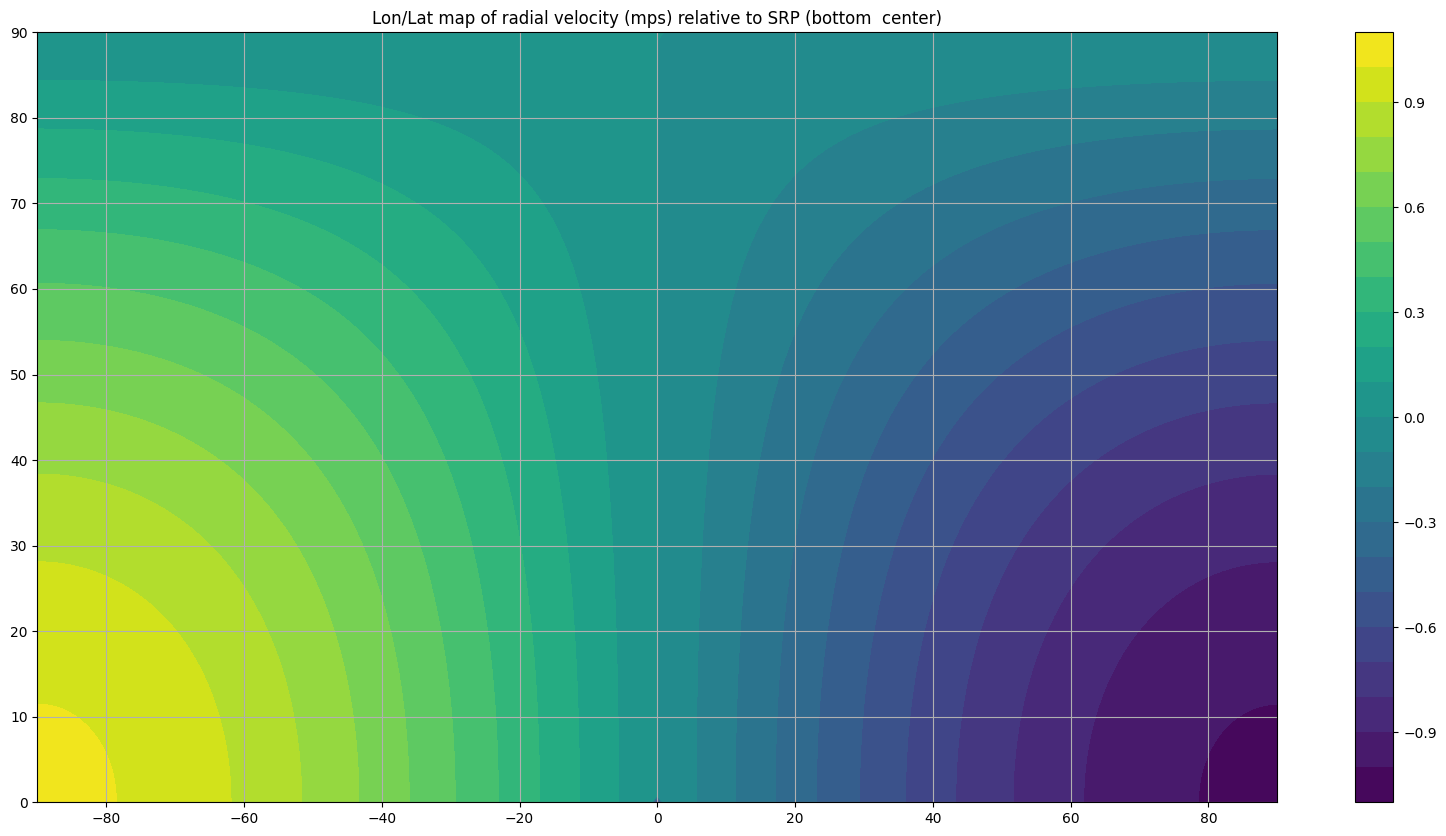

In [91]:
from astropy import units as au
from astropy import coordinates as ac
from astropy import constants as ak
from astropy import time as at
from poliastro.bodies import Venus
from poliastro.frames.fixed import VenusFixed
from poliastro.frames.equatorial import VenusICRS
from poliastro.spheroid_location import SpheroidLocation
import numpy as np

# Set high quality ephemerides
# https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de440_and_de441.pdf appears to recommend de440s for our purposes:
# - de440s : 1849 to 2150 (32 MB)
# - de440 : 1550 to 2650 (114 MB)
# - de441 : -13200 to 17191(3.2 GB)
ac.solar_system_ephemeris.set("de440s")  # JPL Horizons is using de441, which is in the same de44X family. 

#obstime = at.Time('2015-08-15T17:20:30.000')
obstime = at.Time('2015-08-12T15:52:42.000')
#obstime = at.Time('2015-08-15T17:00:58.000')

VenusICRS(obstime=obstime) # WORKAROUND -- for some reason we have to do this once (see https://github.com/poliastro/poliastro/issues/1598)

# Observer point (Arecibo) to ICRS posvel
o_coord = ac.EarthLocation.of_site('arecibo')
o_gcrs = o_coord.get_gcrs(obstime)
o_icrs = o_gcrs.transform_to(ac.ICRS())

# Venus Body Center
vBC_fixed = VenusFixed(obstime=obstime,
                       x=0 * au.m, y=0 * au.m, z=0 * au.m,
                       v_x=0 * au.m / au.s, v_y=0 * au.m / au.s, v_z=0 * au.m / au.s,
                       representation_type='cartesian', differential_type='cartesian')

# Sub Radar point on the surface of Venus (without light delay)
o_fixed = o_gcrs.transform_to(vBC_fixed)
SRP_lon = o_fixed.spherical.lon
SRP_lat = o_fixed.spherical.lat

# Grid on Venus
dlon = np.linspace(-90 / 180 * np.pi, 90 / 180 * np.pi, 201) * au.rad
dlat = np.linspace(0, 90 / 180 * np.pi, 100) * au.rad
dlon_mesh, dlat_mesh = np.meshgrid(dlon, dlat)
shape = dlon_mesh.shape

# Without centering the grid on the SRP
#v0 = SpheroidLocation(dlon_mesh * au.rad, dlat_mesh * au.rad, 0.0 * au.m, Venus)

# Center the grid on the SRP
v0 = SpheroidLocation(dlon_mesh, dlat_mesh, 0.0 * au.m, Venus)
x, y, z = v0.cartesian_cords
X = np.matrix((x.to(au.m).ravel(), y.to(au.m).ravel(), z.to(au.m).ravel()))
# The D matrix rotates by the north-pole to apparent axis-of-rotation angle in the plane of the sky
#doppler_ang = -7.4 * au.deg
doppler_ang = -9.85 * au.deg
#doppler_ang = -apparentRotationAngleDelta_poliastro(obstime)
print(f'{doppler_ang.to(au.deg)=}')
print(f'{doppler_ang.to(au.deg)=}')
cnp = np.cos(doppler_ang.to(au.radian))
snp = np.sin(doppler_ang.to(au.radian))
D = np.matrix(((1,   0,    0),
               (0, cnp, -snp),
               (0, snp,  cnp))) 
# The S matrix rotates the coordinate system to center the SRP.
clon = np.cos(SRP_lon)
clat = np.cos(SRP_lat)
slon = np.sin(SRP_lon)
slat = np.sin(SRP_lat)
S = np.matrix((( clon * clat,  slon * clat, slat),
               (       -slon,         clon,    0),
               (-clon * slat, -slon * slat, clat))) 
X = S.T * D.T * X

x = X[0].A.reshape(shape) * au.m
y = X[1].A.reshape(shape) * au.m
z = X[2].A.reshape(shape) * au.m

# Angular velocity in VenusFixed frame
om = np.array((0, 0, Venus.angular_velocity.value))
dX = np.cross(om, X.T)
v_x = dX[:, 0].reshape(shape) * au.m / au.s
v_y = dX[:, 1].reshape(shape) * au.m / au.s
v_z = dX[:, 2].reshape(shape) * au.m / au.s

v_fixed = VenusFixed(obstime=obstime,
                     x=x, y=y, z=z,
                     v_x=v_x, v_y=v_y, v_z=v_z,
                     representation_type='cartesian', differential_type='cartesian')
v_icrs = v_fixed.transform_to(ac.ICRS())

# Delta position and velocity
dpos = v_icrs.cartesian.without_differentials() - o_icrs.cartesian.without_differentials()
dvel = v_icrs.velocity - o_icrs.velocity

dpos_m = dpos.xyz.to(au.m).value
dvel_mps = dvel.d_xyz.to(au.m / au.s).value
range_m = np.sqrt(np.sum(dpos_m**2, axis=0))

# "Radial" and "Orthogonal" velocity
speed_mps = np.sqrt(np.sum(dvel_mps**2, axis=0))
radial_mps = np.sum(dvel_mps * dpos_m / range_m, axis=0)  # dot product
ortho_mps = np.sqrt(speed_mps**2 - radial_mps**2)

print('range_m ', range_m[0, 100])
print('radial_mps', radial_mps[0, 100])

# TWO ISSUES
# 1. radial_mps at the SRP doesn't seem to match JPL horizons by about 2 m/s
# 2. the grid isn't centered by my doppler angle!!! Bruce's doppler angle is better! Indicates a bug!

if 1: # plots
    from matplotlib import pylab as pl

    #pl.figure()
    ##pl.plot(v_x)
    ##pl.plot(v_y)
    ##pl.plot(v_z)
    #pl.plot(np.sqrt(v_x**2 + v_y**2 + v_z**2))

    #R = range_m.copy()
    #R = speed_mps.copy()
    R = radial_mps.copy()
    #R = ortho_mps.copy()

    R -= R[0, 100]  # Zero velocities to the SRP value
    # Artificially set the SRP point value (which is notionally zero) so that the visualized velocities are symmetric (|max| == |min|)
    if R.max() > -R.min():
      R[0, 100] = -R.max()  
    else:
      R[0, 100] = -R.min()

    pl.figure(figsize=(20,10))
    pl.contourf(dlon_mesh.to(au.deg), dlat_mesh.to(au.deg), R, levels=20)
    pl.colorbar()
    pl.grid()
    pl.title('Lon/Lat map of radial velocity (mps) relative to SRP (bottom  center)')

-80.15301530153015 deg
9.855985598559855 deg


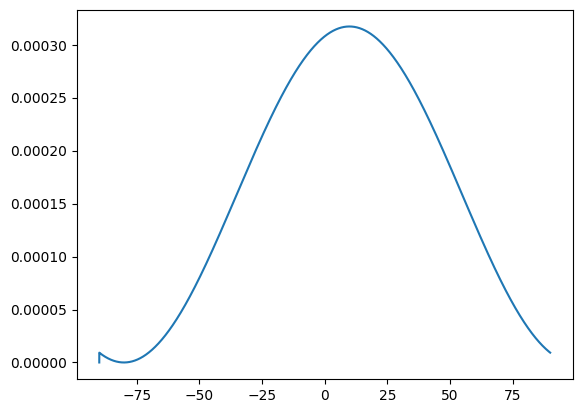

In [116]:
def dopplerAngle_poliastro_SEARCH(obstime):
    # Observer point (Arecibo) to ICRS posvel
    o_coord = ac.EarthLocation.of_site('arecibo')
    o_gcrs = o_coord.get_gcrs(obstime)
    o_icrs = o_gcrs.transform_to(ac.ICRS())

    # Venus Body Center
    vBC_fixed = VenusFixed(obstime=obstime,
                           x=0 * au.m, y=0 * au.m, z=0 * au.m,
                           v_x=0 * au.m / au.s, v_y=0 * au.m / au.s, v_z=0 * au.m / au.s,
                           representation_type='cartesian', differential_type='cartesian')

    # Sub Radar point on the surface of Venus (without light delay)
    o_fixed = o_gcrs.transform_to(vBC_fixed)
    SRP_lon = o_fixed.spherical.lon
    SRP_lat = o_fixed.spherical.lat

    da = np.linspace(-90 * au.deg, 90 * au.deg, 10000)
    shape = da.shape
    dist = 1 * au.deg
    dlon = np.cos(da) * dist
    dlat = np.sin(da) * dist
    # Zero the first entry, which will be the SRP itself
    dlon[0] *= 0
    dlat[0] *= 0
    s = SpheroidLocation(dlon, dlat, 0.0 * au.m, Venus)
    x, y, z = s.cartesian_cords
    X = np.matrix((x.to(au.m).ravel(), y.to(au.m).ravel(), z.to(au.m).ravel()))

    # The S matrix rotates the coordinate system to center the SRP.
    clon = np.cos(SRP_lon)
    clat = np.cos(SRP_lat)
    slon = np.sin(SRP_lon)
    slat = np.sin(SRP_lat)
    S = np.matrix((( clon * clat,  slon * clat, slat),
                   (       -slon,         clon,    0),
                   (-clon * slat, -slon * slat, clat))) 
    X = S.T * X

    x = X[0].A.reshape(shape) * au.m
    y = X[1].A.reshape(shape) * au.m
    z = X[2].A.reshape(shape) * au.m

    # Angular velocity in VenusFixed frame
    om = np.array((0, 0, Venus.angular_velocity.value))
    dX = np.cross(om, X.T)
    v_x = dX[:, 0].reshape(shape) * au.m / au.s
    v_y = dX[:, 1].reshape(shape) * au.m / au.s
    v_z = dX[:, 2].reshape(shape) * au.m / au.s

    v_fixed = VenusFixed(obstime=obstime,
                         x=x, y=y, z=z,
                         v_x=v_x, v_y=v_y, v_z=v_z,
                         representation_type='cartesian', differential_type='cartesian')
    v_icrs = v_fixed.transform_to(ac.ICRS())

    # Delta position and velocity
    dpos = v_icrs.cartesian.without_differentials() - o_icrs.cartesian.without_differentials()
    dvel = v_icrs.velocity - o_icrs.velocity

    dpos_m = dpos.xyz.to(au.m).value
    dvel_mps = dvel.d_xyz.to(au.m / au.s).value
    range_m = np.sqrt(np.sum(dpos_m**2, axis=0))

    # "Radial" and "Orthogonal" velocity
    speed_mps = np.sqrt(np.sum(dvel_mps**2, axis=0))
    radial_mps = np.sum(dvel_mps * dpos_m / range_m, axis=0)  # dot product
    ortho_mps = np.sqrt(speed_mps**2 - radial_mps**2)

    dr = radial_mps - radial_mps[0]
    max_i = np.argmin(dr[1:]**2) + 1
    return da[min_i] + 90